In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from IPython.display import HTML

from data_funcs_and_classes import AnimatedScatter, generate_data, UMIDataset

In [2]:
data, labels = generate_data()

loader = DataLoader(UMIDataset(torch.from_numpy(data), torch.from_numpy(labels)), batch_size=32, shuffle=True)

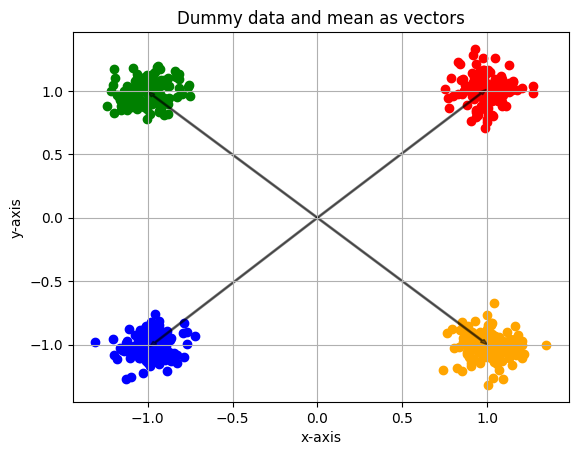

In [3]:
plt.close()
fig, ax = plt.subplots(1)#, sharex='col', sharey='row', gridspec_kw={'wspace': 0})

colors = ['red','green','blue','orange']
means = np.mean(np.reshape(data,(4,int(data.shape[0]/4),data.shape[-1])),axis=1)
cluster_N = int(data.shape[0] / 4)
for color,mean,i in zip(colors,means,range(len(colors))):
    ax.scatter(data[i*cluster_N:(i+1)*cluster_N,0],data[i*cluster_N:(i+1)*cluster_N,1],color=color)
    ax.arrow(0,0,mean[0],mean[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))
plt.title('Dummy data and mean as vectors')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.grid('on')

In [4]:
class UMINN(nn.Module):
    def __init__(self, in_size = 2, out_size = 4, lr = 0.01, bias = False):
        super().__init__()
        self.L1 = nn.Linear(in_size, out_size, bias = bias)
        self.L = nn.CrossEntropyLoss()
        self.opt = Adam(self.parameters(), lr = lr)
    
    def forward(self, x):
        x = self.L1(x)
        return F.softmax(x, dim = -1)
    
    def loss_fn(self, x, y):
        y_pred = self(x.float())
        loss = self.L(y_pred, y)
        return loss
    
    def train_step(self, data, labels):
        self.opt.zero_grad()
        loss = self.loss_fn(data, labels.long())
        loss.backward()
        self.opt.step()
        return loss.item()

class RNN(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 4, output_size = 4, lr = 0.01, bias = False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, bias = bias)
        self.i2o = nn.Linear(input_size + hidden_size, output_size, bias = bias)
        self.L = nn.CrossEntropyLoss()
        self.opt = optim.Adam(self.parameters(), lr = lr)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = F.softmax(output, dim = -1)
        return output, hidden

    def loss_fn(self, x, y):
        y_pred, _ = self.forward(x, torch.zeros(1, self.hidden_size))
        loss = self.L(y_pred, y)
        return loss

    def train_step(self, data, labels):
        self.opt.zero_grad()
        loss = self.loss_fn(data, labels)
        loss.backward()
        self.opt.step()
        return loss.item()



def train(dl, model, lr = 0.01, n_epochs = 2):
    losses = []
    epochs = []
    weights = []
    
    for epoch in range(n_epochs):
        #print(f"Epoch {epoch}")
        N = len(loader)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for i, (data, labels) in enumerate(loader):
            epochs.append(epoch + i/N)
            #weights.append(next(model.parameters()))
            loss_data = model.train_step(data, labels)
            losses.append(loss_data)
    return losses, epochs, weights
            

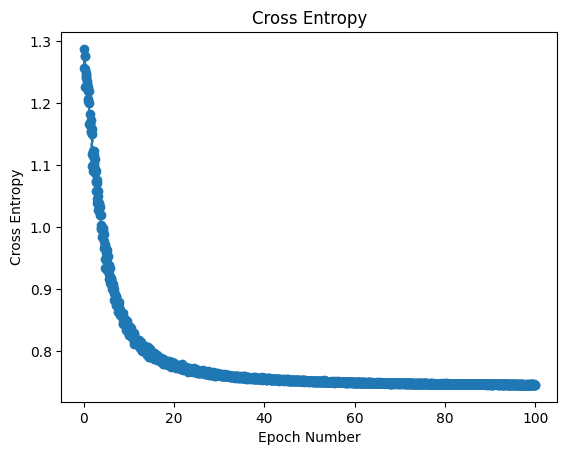

In [5]:
model = UMINN()
lr = 0.01
n_epochs = 100
losses, epochs, weights = train(loader, model, lr, n_epochs)

plt.plot(epochs, losses, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
_ = plt.title('Cross Entropy')

In [6]:
print(weights[-1])

[[ 3.0578806  3.36204  ]
 [-3.4036229  3.2891877]
 [-3.267769  -3.314763 ]
 [ 2.9020188 -3.269926 ]]


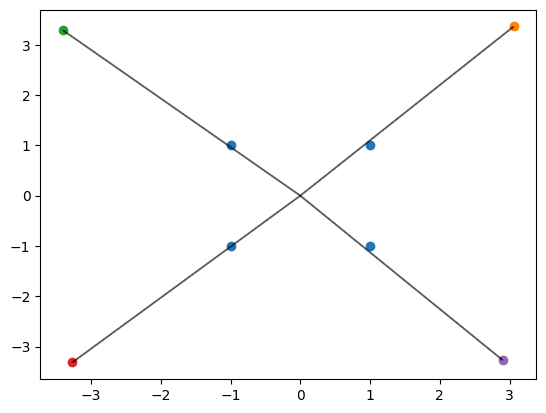

In [7]:
plt.scatter([-1, -1, 1, 1], [1, -1, 1, -1])
for point in weights[-1]:
    plt.scatter(point[0], point[1])
    plt.arrow(0, 0, point[0], point[1], length_includes_head=True,width=0.01,color=(0,0,0,0.5))

In [8]:
test_data, test_labels = generate_data()
#print(model(torch.tensor(test_data)).argmax(dim=1))
#print(torch.tensor(test_labels))
acc = (model(torch.tensor(test_data)).argmax(dim=1) == torch.tensor(test_labels)).float().sum().item()/len(test_labels)
print(acc)

1.0


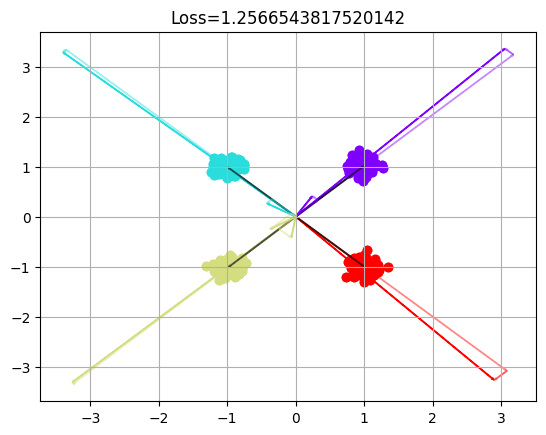

In [9]:
animated_scatter = AnimatedScatter(data, np.array(weights).transpose([0, 2, 1]), losses[::16], n_clusters = 4, acc = acc)
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object

In [10]:
def generate_rotated_data():
    data, labels = generate_data()
    t_values = np.arange(0, 360, 3) # Length 120
    
    
    
    return data, t_values, labels
    
data, t_values, labels = generate_rotated_data()
print(data.shape)

(512, 2)
